## VAE based clusteing

In [1]:
from time import time
from keras.datasets import mnist
import numpy as np
np.random.seed(10)
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics

from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np
import os 
from keras.preprocessing.image import load_img
import _pickle as cPickle
import _pickle 
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline
import gzip
import numpy as np
from PIL import Image
import matplotlib
import os
# For plotting graphs via ssh with no display
# Ref: https://stackoverflow.com/questions/2801882/generating-a-png-with-matplotlib-when-display-is-undefined
matplotlib.use('Agg')
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
from numpy import float32
from sklearn import metrics
from sklearn.cluster.k_means_ import KMeans
from sklearn import manifold
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn import preprocessing
from sklearn.utils import shuffle

Using TensorFlow backend.
c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


### Load breast biohistology images for convolutional input

In [2]:
def loadDataset():
    data= []
    labels =[]
    root ='/home/rkarim/Training_data/'

    for rootName,dirName,fileNames in os.walk(root):
        if(not rootName == root):
            for fileName in fileNames:
                imgGray = load_img(rootName+'/'+fileName,color_mode='grayscale')
                if rootName.split('/')[1] == 'Benign':
                    labels+=[0]
                elif rootName.split('/')[1]== 'InSitu':
                    labels+=[1]
                elif rootName.split('/')[1]  == 'Invasive':
                    labels+=[2]
                else:
                    labels+=[3]
                  
                transformed=transform.resize(np.array(imgGray),(508,508))
                data += [transformed.reshape((transformed.shape[0],transformed.shape[1],1))]        
          
    data = np.stack(data)
    labels = np.stack(labels)
    #data,labels = shuffle(data,labels,random_state = 0)
    
    return [data,labels]

In [18]:
x, y =  loadDataset()

In [19]:
y = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
     1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
     2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
     2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
     3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
     3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

y = np.array(y)

In [20]:
data = x.astype('float32') / 255.
#x = np.reshape(x, (len(x), 508, 508))  # adapt this if using `channels_first` image data format
data.shape
#data = np.reshape(data, (len(data), 508, 508))
data = data.reshape((len(data), np.prod(data.shape[1:])))

In [21]:
n_clusters = len(np.unique(y))
print("Number of cluster: " + str(n_clusters))
print("Input shape: " + str(data.shape))

print("Timestep: " + str(data.shape[0]))
print("Data dimension: " + str(data.shape[1]))

Number of cluster: 4
Input shape: (266, 258064)
Timestep: 266
Data dimension: 258064


In [3]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [4]:
n_clusters = len(np.unique(y))
print("Number of cluster: " + str(n_clusters))
print("Input shape: " + str(X.shape))

print("Timestep: " + str(X.shape[0]))
print("Data dimension: " + str(X.shape[1]))

Number of cluster: 10
Input shape: (70000, 784)
Timestep: 70000
Data dimension: 784


In [14]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import BatchNormalization
  
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
bn = BatchNormalization()(h)
do = Dropout(0.5)(bn)

z_mean = Dense(latent_dim)(do)
z_mean = BatchNormalization()(z_mean)
z_mean = Dropout(0.5)(z_mean)

z_log_sigma = Dense(latent_dim)(do)

z_log_var = Dense(latent_dim, name='z_log_var')(x)
z_log_var = BatchNormalization()(z_log_var)
z_log_var = Dropout(0.5)(z_log_var)

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

decoder_h = Dense(512, activation='relu')

decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [15]:
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

In [16]:
autoencoder, encoder = vae, encoder
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (128, 784)           0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (128, 512)           401920      input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (128, 512)           2048        dense_17[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (128, 512)           0           batch_normalization_8[0][0]      
__________________________________________________________________________________________________
dense_18 (

### Pretrain VAE  autoencoder

In [54]:
pretrain_epochs = 100
batch_size = 128
save_dir = 'results/'

In [55]:
autoencoder.compile(optimizer='adam', loss=vae_loss)

In [56]:
autoencoder.fit(X[0:69760], X[0:69760], batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

Epoch 1/100
69760/69760 [==============================] - ETA: 0s - loss: 0.263 - 11s 161us/step - loss: 0.2630
Epoch 2/100
69760/69760 [==============================] - 11s 156us/step - loss: 0.2630
Epoch 3/100
69760/69760 [==============================] - 11s 165us/step - loss: 0.2630
Epoch 4/100
69760/69760 [==============================] - 11s 160us/step - loss: 0.2630
Epoch 5/100
69760/69760 [==============================] - 10s 142us/step - loss: 0.2630
Epoch 6/100
69760/69760 [==============================] - 9s 135us/step - loss: 0.2630
Epoch 7/100
69760/69760 [==============================] - 9s 129us/step - loss: 0.2630
Epoch 8/100
69760/69760 [==============================] - 9s 128us/step - loss: 0.2630
Epoch 9/100
69760/69760 [==============================] - 9s 129us/step - loss: 0.2630
Epoch 10/100
69760/69760 [==============================] - 9s 134us/step - loss: 0.2630
Epoch 11/100
69760/69760 [==============================] - 10s 145us/step - loss: 0.2630


In [57]:
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

### Build clustering model with convolutional autoencoder

In [58]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [59]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer='adam', loss='kld')

### Step 1: initialize cluster centers using k-means

In [60]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred_kmeans = kmeans.fit_predict(encoder.predict(X))

In [61]:
metrics.accuracy_score(y, y_pred_kmeans)

0.11252857142857142

In [62]:
y_pred_last = np.copy(y_pred_kmeans)

In [63]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering

In [64]:
#computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [65]:
loss = 0
index = 0
maxiter = 10000
update_interval = 100
index_array = np.arange(X.shape[0])

In [68]:
tol = 0.0001 # tolerance threshold to stop training

### Start training

In [69]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(X, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.accuracy_score(y, y_pred), 5)
            nmi = np.round(metrics.mutual_info_score(y, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, X.shape[0])]
    loss = model.train_on_batch(x=X[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= X.shape[0] else 0

model.save_weights(save_dir + '/conv_DEC_model_final.h5')

Iter 0: acc = 0.09861, nmi = -0.00000, ari = 0.00000  ; loss= 0.0
Iter 100: acc = 0.09861, nmi = -0.00000, ari = 0.00000  ; loss= 0.0
delta_label  0.0 < tol  0.0001
Reached tolerance threshold. Stopping training.


### Load the clustering model trained weights

In [70]:
model.load_weights(save_dir + '/conv_DEC_model_final.h5')

### Final Evaluation

In [71]:
#Eval.

q = model.predict(X, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.accuracy_score(y, y_pred), 2)
    nmi = np.round(metrics.mutual_info_score(y, y_pred), 2)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 2)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.10000, nmi = -0.00000, ari = 0.00000  ; loss= 0.0


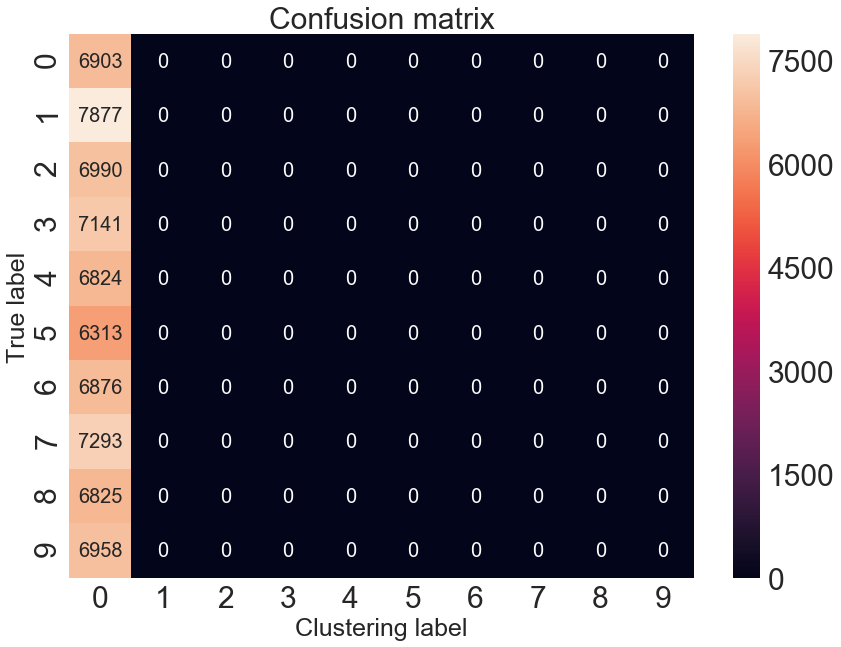

In [72]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [73]:
def vis_data(x_train_encoded, y_train, vis_dim, n_predict, n_train, build_anim):
    cmap = plt.get_cmap('rainbow', 20)

    # 3-dim vis: show one view, then compile animated .gif of many angled views
    if vis_dim == 3:
        # Simple static figure
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        p = ax.scatter3D(x_train_encoded[:,0], x_train_encoded[:,1], x_train_encoded[:,2], 
                c=y_train[:n_predict], cmap=cmap, edgecolor='black')
        fig.colorbar(p, drawedges=True)
        plt.show()

        # Build animation from many static figures
        if build_anim:
            angles = np.linspace(180, 360, 20)
            i = 0
            for angle in angles:
                fig = plt.figure()
                ax = plt.axes(projection='3d')
                ax.view_init(10, angle)
                p = ax.scatter3D(x_train_encoded[:,0], x_train_encoded[:,1], x_train_encoded[:,2], 
                        c=y_train[:n_predict], cmap=cmap, edgecolor='black')
                fig.colorbar(p, drawedges=True)
                outfile = 'anim/3dplot_step_' + chr(i + 97) + '.png'
                plt.savefig(outfile, dpi=96)
                i += 1
            call(['convert', '-delay', '50', 'anim/3dplot*', 'anim/3dplot_anim_' + str(n_train) + '.gif'])

    # 2-dim vis: plot and colorbar.
    elif vis_dim == 2:
        plt.scatter(x_train_encoded[:,0], x_train_encoded[:,1], 
                c=y_train[:n_predict], edgecolor='black', cmap=cmap)
        plt.colorbar(drawedges=True)
        plt.show()

In [74]:
# Encode a number of MNIST digits, then perform t-SNE dim-reduction.
x_train_predict = encoder.predict(X)

#print "Performing t-SNE dimensionality reduction..."
x_train_encoded = TSNE(n_components=2).fit_transform(x_train_predict)
#np.save('%sx_%sdim_tnse_%s.npy' % (266, 2, 266), x_train_encoded)
#x_train_encoded = np.load(str(n_predict) + 'x_' + str(vis_dim) + 'dim_tnse_' + str(n_train) + '.npy')


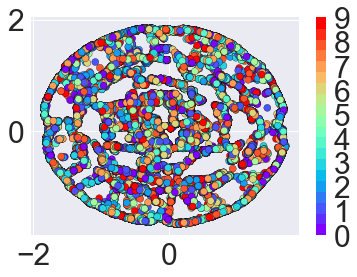

In [75]:
# Visualize result.
train_new = False
n_train = 70000
predict_new = False
n_predict = 70000
vis_dim = 2
build_anim = False
    
vis_data(x_train_encoded, y, vis_dim, n_predict, n_train, build_anim)